In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset

import numpy as np
import csv
import os

from layers import FDNN
from tqdm import tqdm
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

import sklearn
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn import preprocessing

import pandas as pd

In [2]:
def get_device():
    ''' Get device (if GPU is available, use GPU) '''
    return 'cuda' if torch.cuda.is_available() else 'cpu'
def plot_learning_curve(loss_record, title=''):
    ''' Plot learning curve of your DNN (train & dev loss) '''
    total_steps = len(loss_record['train'])
    x_1 = range(total_steps)
    x_2 = x_1[::len(loss_record['train']) // len(loss_record['dev'])]
    figure(figsize=(6, 4))
    plt.plot(x_1, loss_record['train'], c='tab:red', label='train')
    plt.plot(x_2, loss_record['dev'], c='tab:cyan', label='dev')
    plt.ylim(0.0, 10.)
    plt.xlabel('Training steps')
    plt.ylabel('MSE loss')
    plt.title('Learning curve of {}'.format(title))
    plt.legend()
    plt.show()


def plot_pred(dv_set, model, device, lim=35., preds=None, targets=None):
    ''' Plot prediction of your DNN '''
    if preds is None or targets is None:
        model.eval()
        preds, targets = [], []
        for x, y in dv_set:
            x, y = x.to(device), y.to(device)
            with torch.no_grad():
                pred = model(x)
                preds.append(pred.detach().cpu())
                targets.append(y.detach().cpu())
        preds = torch.cat(preds, dim=0).numpy()
        targets = torch.cat(targets, dim=0).numpy()

    figure(figsize=(5, 5))
    plt.scatter(targets, preds, c='r', alpha=0.5)
    plt.plot([-0.2, lim], [-0.2, lim], c='b')
    plt.xlim(-0.2, lim)
    plt.ylim(-0.2, lim)
    plt.xlabel('ground truth value')
    plt.ylabel('predicted value')
    plt.title('Ground Truth v.s. Prediction')
    plt.show()

In [3]:
# Feature Selection

data = pd.read_csv(r'./data/covid/covid.train.csv')
x = data[data.columns[1:94]]
y = data[data.columns[94]]

# Normalisation
x = (x - x.min()) / (x.max() - x.min())

# Create an instance of SelectKBest without specifying 'k'
bestfeatures = SelectKBest(score_func=f_regression)

# Compute the scores for all features
fit = bestfeatures.fit(x,y)

# Convert the scores into a DataFrame
dfscores = pd.DataFrame(fit.scores_)

# Create a DataFrame of the column names
dfcolumns = pd.DataFrame(x.columns)

# Concatenate the two DataFrames for better visualization
featureScores = pd.concat([dfcolumns,dfscores],axis=1)

# Name the DataFrame columns
featureScores.columns = ['Specs','Score']  

# Print the 20 rows with the highest scores
print(featureScores.nlargest(20,'Score'))  

# Print the index of the most important features
top_rows = featureScores.nlargest(20, 'Score').index.tolist()[:17]

                 Specs          Score
75   tested_positive.1  148069.658278
57     tested_positive   69603.872591
42        hh_cmnty_cli    9235.492094
60      hh_cmnty_cli.1    9209.019558
78      hh_cmnty_cli.2    9097.375172
43      nohh_cmnty_cli    8395.421300
61    nohh_cmnty_cli.1    8343.255927
79    nohh_cmnty_cli.2    8208.176435
40                 cli    6388.906849
58               cli.1    6374.548000
76               cli.2    6250.008702
41                 ili    5998.922880
59               ili.1    5937.588576
77               ili.2    5796.947672
92  worried_finances.2     833.613191
74  worried_finances.1     811.916460
56    worried_finances     788.076931
87    public_transit.2     686.736539
69    public_transit.1     681.562902
51      public_transit     678.834789


In [4]:
class COVID19Dataset(Dataset):
    ''' Dataset for loading and preprocessing the COVID19 dataset '''
    def __init__(self,
                 path,
                 mode='train',
                 target_only=True):
        self.mode = mode

        # Read data into numpy arrays
        with open(path, 'r') as fp:
            data = list(csv.reader(fp))
            data = np.array(data[1:])[:, 1:].astype(float)
        
        if not target_only:
            feats = list(range(93))
        else:
            # TODO: Using 40 states & 2 tested_positive features (indices = 57 & 75)
            feats = [75, 57, 42, 60, 78, 43, 61, 79, 40, 58, 76, 41, 59, 77, 92, 74, 56]

        if mode == 'test':
            # Testing data
            # data: 893 x 93 (40 states + day 1 (18) + day 2 (18) + day 3 (17))
            data = data[:, feats]
            self.data = torch.FloatTensor(data)
        else:
            # Training data (train/dev sets)
            # data: 2700 x 94 (40 states + day 1 (18) + day 2 (18) + day 3 (18))
            target = data[:, -1]
            data = data[:, feats]
            
            # Splitting training data into train & dev sets
            if mode == 'train':
                indices = [i for i in range(len(data)) if i % 10 != 0]
            elif mode == 'dev':
                indices = [i for i in range(len(data)) if i % 10 == 0]
            
            # Convert data into PyTorch tensors
            self.data = torch.FloatTensor(data[indices])
            self.target = torch.FloatTensor(target[indices])

        # Normalize features (you may remove this part to see what will happen)
        self.data[:, 40:] = \
            (self.data[:, 40:] - self.data[:, 40:].mean(dim=0, keepdim=True)) \
            / self.data[:, 40:].std(dim=0, keepdim=True)

        self.dim = self.data.shape[1]

        print('Finished reading the {} set of COVID19 Dataset ({} samples found, each dim = {})'
              .format(mode, len(self.data), self.dim))

    def __getitem__(self, index):
        # Returns one sample at a time
        if self.mode in ['train', 'dev']:
            # For training
            return self.data[index], self.target[index]
        else:
            # For testing (no target)
            return self.data[index]

    def __len__(self):
        # Returns the size of the dataset
        return len(self.data)

In [5]:
def prep_dataloader(path, mode, batch_size, n_jobs=0, target_only=False):
    ''' Generates a dataset, then is put into a dataloader. '''
    dataset = COVID19Dataset(path, mode=mode, target_only=target_only)  # Construct dataset
    dataloader = DataLoader(
        dataset, batch_size,
        shuffle=(mode == 'train'), drop_last=False,
        num_workers=n_jobs, pin_memory=True)                # Construct dataloader
    return dataloader

In [6]:
# **Deep Neural Network**

class NeuralNet(nn.Module):
    ''' A simple fully-connected deep neural network '''
    def __init__(self, input_dim):
        super(NeuralNet, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 16),
            nn.BatchNorm1d(16),
            nn.Dropout(p=0.2),
            nn.ReLU(),
            nn.Linear(16, 1)
        )

        # Mean squared error loss
        self.criterion = nn.MSELoss(reduction='mean')

    def forward(self, x):
        ''' Given input of size (batch_size x input_dim), compute output of the network '''
        return self.net(x).squeeze(1)
    
    def cal_loss(self, pred, target):
        ''' Calculate loss '''
        regularization_loss = 0
        for param in self.net.parameters():
            regularization_loss += torch.sum(param ** 2)
        return self.criterion(pred, target) + 0.00075 * regularization_loss

In [7]:
## **Training**

from tqdm import tqdm

def train(tr_set, dv_set, model, config, device):
    ''' DNN training '''

    n_epochs = config['n_epochs']  # Maximum number of epochs
    criterion = nn.MSELoss()
    # Setup optimizer
    optimizer = getattr(torch.optim, config['optimizer'])(
        model.parameters(), **config['optim_hparas'])

    min_mse = 1000.
    loss_record = {'train': [], 'dev': []}      # for recording training loss
    early_stop_cnt = 0
    epoch = 0
    pbar = tqdm(total=n_epochs)  # create a progress bar for the epochs
    while epoch < n_epochs:
        model.train()                           # set model to training mode
        train_loss = 0
        for x, y in tr_set:                     # iterate through the dataloader
            optimizer.zero_grad()               # set gradient to zero
            x, y = x.to(device), y.to(device)   # move data to device (cpu/cuda)
            pred = model(x)                     # forward pass (compute output)
            mse_loss = criterion(pred, y)  # compute loss
            for param in model.parameters():
                mse_loss += 0.00075 * torch.sum(param ** 2)
            mse_loss.backward()                 # compute gradient (backpropagation)
            optimizer.step()                    # update model with optimizer
            train_loss += mse_loss.detach().cpu().item()
        loss_record['train'].append(train_loss / len(tr_set))  # append average training loss

        # After each epoch, test your model on the validation (development) set.
        dev_mse = dev(dv_set, model, device)
        if dev_mse < min_mse:
            # Save model if your model improved
            min_mse = dev_mse
            # print('Saving model')
            torch.save(model.state_dict(), config['save_path'])  # Save model to specified path
            early_stop_cnt = 0
        else:
            early_stop_cnt += 1

        epoch += 1
        loss_record['dev'].append(dev_mse)
        if early_stop_cnt > config['early_stop']:
            # Stop training if your model stops improving for "config['early_stop']" epochs.
            break
        
        pbar.update(1)  # update the progress bar for each epoch
    pbar.close()  # close the progress bar after training is finished

    print('Finished training after {} epochs'.format(epoch))
    return min_mse, loss_record


def dev(dv_set, model, device):
    criterion = nn.MSELoss()
    model.eval()                                # set model to evalutation mode
    total_loss = 0
    for x, y in dv_set:                         # iterate through the dataloader
        x, y = x.to(device), y.to(device)       # move data to device (cpu/cuda)
        with torch.no_grad():                   # disable gradient calculation
            pred = model(x)                     # forward pass (compute output)
            mse_loss = criterion(pred, y)  # compute loss
        total_loss += mse_loss.detach().cpu().item() * len(x)  # accumulate loss
    total_loss = total_loss / len(dv_set.dataset)              # compute averaged loss

    return total_loss


In [8]:
def test(tt_set, model, device):
    model.eval()                                # set model to evalutation mode
    preds = []
    for x in tt_set:                            # iterate through the dataloader
        x = x.to(device)                        # move data to device (cpu/cuda)
        with torch.no_grad():                   # disable gradient calculation
            pred = model(x)                     # forward pass (compute output)
            preds.append(pred.detach().cpu())   # collect prediction
    preds = torch.cat(preds, dim=0).numpy()     # concatenate all predictions and convert to a numpy array
    return preds

In [9]:
# **Setup Hyper-parameters**

device = get_device()                 # get the current available device ('cpu' or 'cuda')
os.makedirs('models', exist_ok=True)  # The trained model will be saved to ./models/
target_only = True                   # TODO: Using 40 states & 2 tested_positive features

# TODO: How to tune these hyper-parameters to improve your model's performance?
config = {
    'n_epochs': 10000,                # maximum number of epochs
    'batch_size': 200,               # mini-batch size for dataloader
    'optimizer': 'Adam',              # optimization algorithm (optimizer in torch.optim)
    'optim_hparas': {                # hyper-parameters for the optimizer (depends on which optimizer you are using)
        'lr': 0.0005,                # learning rate of SGD ---0.00185; 0.00181; 0.001811
        # 'momentum': 0.9              # momentum for SGD
    },
    'early_stop': 1000,               # early stopping epochs (the number epochs since your model's last improvement)
    'save_path': 'models/model.pth'  # your model will be saved here
}

In [10]:
# num_epochs = 100
# device = "cuda"
# dropout = 0.12
# experiment_name = "cifar10_DropOut_relu_64"

# model_dir = f'saved_models/{experiment_name}'
# os.makedirs(model_dir, exist_ok=True)

# train_loss_list = []
# test_loss_list = []
# train_accuracy_list = []
# test_accuracy_list = []

# criterion = nn.CrossEntropyLoss()
# model = FDNN(64, 3, 64, 10, 1)
# optimizer = optim.AdamW(model.parameters(), lr=0.001)

In [23]:
# **Load data and model**
tr_path = './data/covid/covid.train.csv'
tt_path = './data/covid/covid.test.csv'
tr_set = prep_dataloader(tr_path, 'train', config['batch_size'], target_only=target_only)
dv_set = prep_dataloader(tr_path, 'dev', config['batch_size'], target_only=target_only)
tt_set = prep_dataloader(tt_path, 'test', config['batch_size'], target_only=target_only)

# model = NeuralNet(tr_set.dataset.dim).to(device)  # Construct model and move to device
model = FDNN(17, 16, 8, 8, 1).to(device)  # Construct model and move to device

Finished reading the train set of COVID19 Dataset (2430 samples found, each dim = 17)
Finished reading the dev set of COVID19 Dataset (270 samples found, each dim = 17)
Finished reading the test set of COVID19 Dataset (893 samples found, each dim = 17)


In [24]:
model_loss, model_loss_record = train(tr_set, dv_set, model, config, device)

 15%|█▍        | 1467/10000 [04:33<26:29,  5.37it/s]

Finished training after 1468 epochs


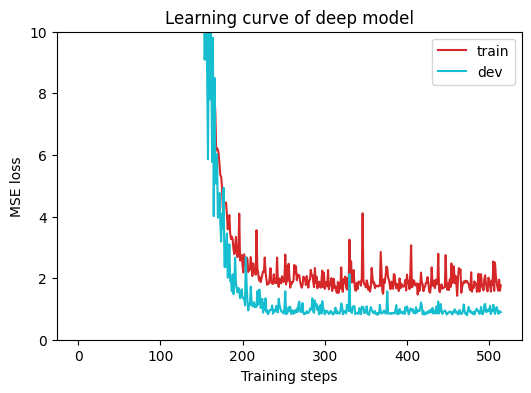

In [22]:
plot_learning_curve(model_loss_record, title='deep model')

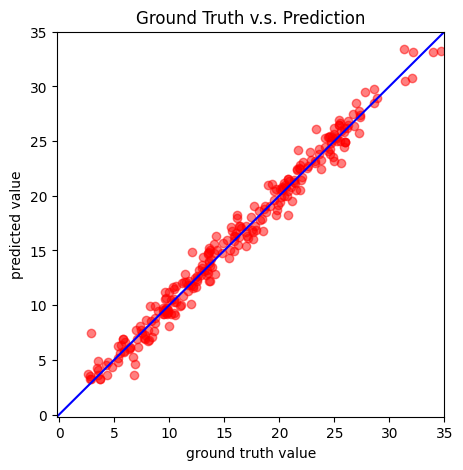

In [14]:
# del model
model = FDNN(17, 2, 8, 8, 1).to(device)
# model = NeuralNet(tr_set.dataset.dim).to(device)
ckpt = torch.load(config['save_path'], map_location='cpu')  # Load your best model
model.load_state_dict(ckpt)
plot_pred(dv_set, model, device) 

In [15]:
def save_pred(preds, file):
    ''' Save predictions to specified file '''
    print('Saving results to {}'.format(file))
    with open(file, 'w') as fp:
        writer = csv.writer(fp)
        writer.writerow(['id', 'tested_positive'])
        for i, p in enumerate(preds):
            writer.writerow([i, p])

preds = test(tt_set, model, device)  # predict COVID-19 cases with your model


In [16]:
save_pred(preds, 'pred.csv')

Saving results to pred.csv
